### Methods & Results:

In [7]:
### Loading Libraries into R
### Run this cell before continuing.
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [8]:
### data is read from online
data <- read_csv(file = "data/music_genre.csv")
data

Parsed with column specification:
cols(
  instance_id = col_double(),
  artist_name = col_character(),
  track_name = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_character(),
  obtained_date = col_character(),
  valence = col_double(),
  music_genre = col_character()
)



instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,04-Apr,0.759,Electronic
46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,04-Apr,0.531,Electronic
30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,04-Apr,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39767,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,D,0.143,-5.443,Major,0.1460,131.079,04-Apr,0.395,Hip-Hop
57944,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,G,0.106,-5.016,Minor,0.0441,75.886,04-Apr,0.354,Hip-Hop
63470,Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,F#,0.272,-13.652,Minor,0.1010,99.201,04-Apr,0.765,Hip-Hop


In [9]:
### removing the columns we don't need
data <- mutate(data,
                  mode = as.factor(mode),
                  music_genre = as.factor(music_genre),
                  tempo = as.numeric(tempo))
data
data_select <- data %>%
            select(-instance_id, -key,-obtained_date)


Warning message:
“Problem with `mutate()` input `tempo`.
ℹ NAs introduced by coercion
ℹ Input `tempo` is `as.numeric(tempo)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,04-Apr,0.759,Electronic
46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,04-Apr,0.531,Electronic
30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,04-Apr,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39767,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,D,0.143,-5.443,Major,0.1460,131.079,04-Apr,0.395,Hip-Hop
57944,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,G,0.106,-5.016,Minor,0.0441,75.886,04-Apr,0.354,Hip-Hop
63470,Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,F#,0.272,-13.652,Minor,0.1010,99.201,04-Apr,0.765,Hip-Hop


In [10]:
### spliting the data into training set and testing set, 75% of the data in the training set
data_split <- initial_split(data_select, prop = 0.75, strata = music_genre) 
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

Warning message:
“Too little data to stratify. Unstratified resampling will be used.”


artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Roy Woods,Drama (feat. Drake),72,0.1570,0.709,251860,0.362,0,0.109,-9.814,Major,0.0550,122.043,0.113,Hip-Hop
The-Dream,Shawty Is Da Shit,65,0.0831,0.782,262773,0.472,0,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop
Naughty By Nature,Hip Hop Hooray,67,0.1020,0.862,267267,0.642,0,0.272,-13.652,Minor,0.1010,99.201,0.765,Hip-Hop


artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Jordan Comolli,Clash,46,0.02890,0.572,214408,0.803,7.74e-06,0.106,-4.294,Major,0.3510,149.995,0.2300,Electronic
Dillon Francis,We Are Impossible (feat. The Presets),33,0.00825,0.659,215280,0.912,0.00e+00,0.543,-4.212,Major,0.0562,109.965,0.5010,Electronic
The Prodigy,Diesel Power,56,0.06800,0.725,-1,0.877,3.62e-05,0.090,-3.496,Major,0.0646,105.919,0.0977,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
empty_field,For Real,53,0.00392,0.770,211820,0.905,2.97e-06,0.169,-8.235,Minor,0.144,135.999,0.464,Hip-Hop
BEXEY,GO GETTA,59,0.03340,0.913,-1,0.574,0.00e+00,0.119,-7.022,Major,0.298,98.028,0.330,Hip-Hop
Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0.00e+00,0.143,-5.443,Major,0.146,131.079,0.395,Hip-Hop


In [6]:
### Table for each Genre
Electronic <- data_train %>%
                filter(music_genre == "Electronic") %>%
                group_by(music_genre) %>%
                summarize(Electronic_popularity = mean(popularity, na.ra = True),
                         Electronic_acousticness = mean(acousticness, na.ra = True),
                         Electronic_danceability = mean(danceability, na.ra = True),
                         Electronic_duration_ms = mean(duration_ms, na.ra = True),
                         Electronic_energy = mean(energy, na.ra = True),
                         Electronic_instrumentalness = mean(instrumentalness, na.ra = True),
                         Electronic_liveness = mean(liveness, na.ra = True),
                         Electronic_loudness = mean(loudness, na.ra = True),
                         Electronic_speechiness = mean(speechiness, na.ra = True),
                         Electronic_tempo = mean(tempo, na.ra = True),
                         Electronic_valence = mean(valence, na.ra = True))
Electronic

Anime <- data_train %>%
                filter(music_genre == "Anime") %>%
                group_by(music_genre) %>%
                summarize(Anime_popularity = mean(popularity, na.ra = True),
                         Anime_acousticness = mean(acousticness, na.ra = True),
                         Anime_danceability = mean(danceability, na.ra = True),
                         Anime_duration_ms = mean(duration_ms, na.ra = True),
                         Anime_energy = mean(energy, na.ra = True),
                         Anime_instrumentalness = mean(instrumentalness, na.ra = True),
                         Anime_liveness = mean(liveness, na.ra = True),
                         Anime_loudness = mean(loudness, na.ra = True),
                         Anime_speechiness = mean(speechiness, na.ra = True),
                         Anime_tempo = mean(tempo, na.ra = True),
                         Anime_valence = mean(valence, na.ra = True))
Anime

Jazz <- data_train %>%
                filter(music_genre == "Jazz") %>%
                group_by(music_genre) %>%
                summarize(Jazz_popularity = mean(popularity, na.ra = True),
                         Jazz_acousticness = mean(acousticness, na.ra = True),
                         Jazz_danceability = mean(danceability, na.ra = True),
                         Jazz_duration_ms = mean(duration_ms, na.ra = True),
                         Jazz_energy = mean(energy, na.ra = True),
                         Jazz_instrumentalness = mean(instrumentalness, na.ra = True),
                         Jazz_liveness = mean(liveness, na.ra = True),
                         Jazz_loudness = mean(loudness, na.ra = True),
                         Jazz_speechiness = mean(speechiness, na.ra = True),
                         Jazz_tempo = mean(tempo, na.ra = True),
                         Jazz_valence = mean(valence, na.ra = True))
Jazz

Alternative <- data_train %>%
                filter(music_genre == "Alternative") %>%
                group_by(music_genre) %>%
                summarize(Alternative_popularity = mean(popularity, na.ra = True),
                         Alternative_acousticness = mean(acousticness, na.ra = True),
                         Alternative_danceability = mean(danceability, na.ra = True),
                         Alternative_duration_ms = mean(duration_ms, na.ra = True),
                         Alternative_energy = mean(energy, na.ra = True),
                         Alternative_instrumentalness = mean(instrumentalness, na.ra = True),
                         Alternative_liveness = mean(liveness, na.ra = True),
                         Alternative_loudness = mean(loudness, na.ra = True),
                         Alternative_speechiness = mean(speechiness, na.ra = True),
                         Alternative_tempo = mean(tempo, na.ra = True),
                         Alternative_valence = mean(valence, na.ra = True))
Alternative

Country <- data_train %>%
                filter(music_genre == "Country") %>%
                group_by(music_genre) %>%
                summarize(Country_popularity = mean(popularity, na.ra = True),
                         Country_acousticness = mean(acousticness, na.ra = True),
                         Country_danceability = mean(danceability, na.ra = True),
                         Country_duration_ms = mean(duration_ms, na.ra = True),
                         Country_energy = mean(energy, na.ra = True),
                         Country_instrumentalness = mean(instrumentalness, na.ra = True),
                         Country_liveness = mean(liveness, na.ra = True),
                         Country_loudness = mean(loudness, na.ra = True),
                         Country_speechiness = mean(speechiness, na.ra = True),
                         Country_tempo = mean(tempo, na.ra = True),
                         Country_valence = mean(valence, na.ra = True))
Country

Rap <- data_train %>%
                filter(music_genre == "Rap") %>%
                group_by(music_genre) %>%
                summarize(Rap_popularity = mean(popularity, na.ra = True),
                         Rap_acousticness = mean(acousticness, na.ra = True),
                         Rap_danceability = mean(danceability, na.ra = True),
                         Rap_duration_ms = mean(duration_ms, na.ra = True),
                         Rap_energy = mean(energy, na.ra = True),
                         Rap_instrumentalness = mean(instrumentalness, na.ra = True),
                         Rap_liveness = mean(liveness, na.ra = True),
                         Rap_loudness = mean(loudness, na.ra = True),
                         Rap_speechiness = mean(speechiness, na.ra = True),
                         Rap_tempo = mean(tempo, na.ra = True),
                         Rap_valence = mean(valence, na.ra = True))
Rap

Blues <- data_train %>%
                filter(music_genre == "Blues") %>%
                group_by(music_genre) %>%
                summarize(Blues_popularity = mean(popularity, na.ra = True),
                         Blues_acousticness = mean(acousticness, na.ra = True),
                         Blues_danceability = mean(danceability, na.ra = True),
                         Blues_duration_ms = mean(duration_ms, na.ra = True),
                         Blues_energy = mean(energy, na.ra = True),
                         Blues_instrumentalness = mean(instrumentalness, na.ra = True),
                         Blues_liveness = mean(liveness, na.ra = True),
                         Blues_loudness = mean(loudness, na.ra = True),
                         Blues_speechiness = mean(speechiness, na.ra = True),
                         Blues_tempo = mean(tempo, na.ra = True),
                         Blues_valence = mean(valence, na.ra = True))
Blues

Rock <- data_train %>%
                filter(music_genre == "Rock") %>%
                group_by(music_genre) %>%
                summarize(Rock_popularity = mean(popularity, na.ra = True),
                         Rock_acousticness = mean(acousticness, na.ra = True),
                         Rock_danceability = mean(danceability, na.ra = True),
                         Rock_duration_ms = mean(duration_ms, na.ra = True),
                         Rock_energy = mean(energy, na.ra = True),
                         Rock_instrumentalness = mean(instrumentalness, na.ra = True),
                         Rock_liveness = mean(liveness, na.ra = True),
                         Rock_loudness = mean(loudness, na.ra = True),
                         Rock_speechiness = mean(speechiness, na.ra = True),
                         Rock_tempo = mean(tempo, na.ra = True),
                         Rock_valence = mean(valence, na.ra = True))
Rock

Classical <- data_train %>%
                filter(music_genre == "Classical") %>%
                group_by(music_genre) %>%
                summarize(Classical_popularity = mean(popularity, na.ra = True),
                         Classical_acousticness = mean(acousticness, na.ra = True),
                         Classical_danceability = mean(danceability, na.ra = True),
                         Classical_duration_ms = mean(duration_ms, na.ra = True),
                         Classical_energy = mean(energy, na.ra = True),
                         Classical_instrumentalness = mean(instrumentalness, na.ra = True),
                         Classical_liveness = mean(liveness, na.ra = True),
                         Classical_loudness = mean(loudness, na.ra = True),
                         Classical_speechiness = mean(speechiness, na.ra = True),
                         Classical_tempo = mean(tempo, na.ra = True),
                         Classical_valence = mean(valence, na.ra = True))
Classical

Hip_Hop <- data_train %>%
                filter(music_genre == "Hip-Hop") %>%
                group_by(music_genre) %>%
                summarize(Hip_Hop_popularity = mean(popularity, na.ra = True),
                         Hip_Hop_acousticness = mean(acousticness, na.ra = True),
                         Hip_Hop_danceability = mean(danceability, na.ra = True),
                         Hip_Hop_duration_ms = mean(duration_ms, na.ra = True),
                         Hip_Hop_energy = mean(energy, na.ra = True),
                         Hip_Hop_instrumentalness = mean(instrumentalness, na.ra = True),
                         Hip_Hop_liveness = mean(liveness, na.ra = True),
                         Hip_Hop_loudness = mean(loudness, na.ra = True),
                         Hip_Hop_speechiness = mean(speechiness, na.ra = True),
                         Hip_Hop_tempo = mean(tempo, na.ra = True),
                         Hip_Hop_valence = mean(valence, na.ra = True))
Hip_Hop

`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Electronic_popularity,Electronic_acousticness,Electronic_danceability,Electronic_duration_ms,Electronic_energy,Electronic_instrumentalness,Electronic_liveness,Electronic_loudness,Electronic_speechiness,Electronic_tempo,Electronic_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Electronic,38.22575,0.1209939,0.618519,243912.9,0.7399248,0.3485196,0.2083236,-7.010459,0.09833774,NA,0.3896082


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Anime_popularity,Anime_acousticness,Anime_danceability,Anime_duration_ms,Anime_energy,Anime_instrumentalness,Anime_liveness,Anime_loudness,Anime_speechiness,Anime_tempo,Anime_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anime,24.09718,0.2890184,0.4710687,207262.7,0.6627203,0.275544,0.1933312,-8.005073,0.06436032,NA,0.4368915


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Jazz_popularity,Jazz_acousticness,Jazz_danceability,Jazz_duration_ms,Jazz_energy,Jazz_instrumentalness,Jazz_liveness,Jazz_loudness,Jazz_speechiness,Jazz_tempo,Jazz_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jazz,40.99515,0.4970666,0.5831851,238672.1,0.4746398,0.3549998,0.1733287,-11.20497,0.07353367,NA,0.5072553


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Alternative_popularity,Alternative_acousticness,Alternative_danceability,Alternative_duration_ms,Alternative_energy,Alternative_instrumentalness,Alternative_liveness,Alternative_loudness,Alternative_speechiness,Alternative_tempo,Alternative_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alternative,50.09514,0.1635462,0.5396419,211248.6,0.7094808,0.06034778,0.1972803,-6.536998,0.08748621,NA,0.4433511


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Country_popularity,Country_acousticness,Country_danceability,Country_duration_ms,Country_energy,Country_instrumentalness,Country_liveness,Country_loudness,Country_speechiness,Country_tempo,Country_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Country,45.99337,0.2696001,0.5781955,196101.2,0.6373636,0.005948961,0.1889046,-7.325569,0.04915162,NA,0.5380232


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Rap_popularity,Rap_acousticness,Rap_danceability,Rap_duration_ms,Rap_energy,Rap_instrumentalness,Rap_liveness,Rap_loudness,Rap_speechiness,Rap_tempo,Rap_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rap,60.43875,0.1688095,0.6974137,196701.3,0.6510017,0.00856776,0.1980093,-6.649976,0.1848943,NA,0.4543872


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Blues_popularity,Blues_acousticness,Blues_danceability,Blues_duration_ms,Blues_energy,Blues_instrumentalness,Blues_liveness,Blues_loudness,Blues_speechiness,Blues_tempo,Blues_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Blues,34.84956,0.3172375,0.5292278,229227.6,0.6096369,0.0931598,0.2318851,-8.997518,0.06163273,NA,0.5804361


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Rock_popularity,Rock_acousticness,Rock_danceability,Rock_duration_ms,Rock_energy,Rock_instrumentalness,Rock_liveness,Rock_loudness,Rock_speechiness,Rock_tempo,Rock_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rock,59.63176,0.1931467,0.5384534,211565.1,0.6864833,0.05437693,0.1856192,-7.243957,0.05418654,NA,0.5208675


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Classical_popularity,Classical_acousticness,Classical_danceability,Classical_duration_ms,Classical_energy,Classical_instrumentalness,Classical_liveness,Classical_loudness,Classical_speechiness,Classical_tempo,Classical_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Classical,29.42083,0.8706519,0.3064975,275081.6,0.1749546,0.6042624,0.1603967,-21.68719,0.05127208,NA,0.2107748


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Hip_Hop_popularity,Hip_Hop_acousticness,Hip_Hop_danceability,Hip_Hop_duration_ms,Hip_Hop_energy,Hip_Hop_instrumentalness,Hip_Hop_liveness,Hip_Hop_loudness,Hip_Hop_speechiness,Hip_Hop_tempo,Hip_Hop_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hip-Hop,58.31727,0.1789183,0.7177655,198778.2,0.6463703,0.01167107,0.2021532,-6.840464,0.2080488,NA,0.4758049


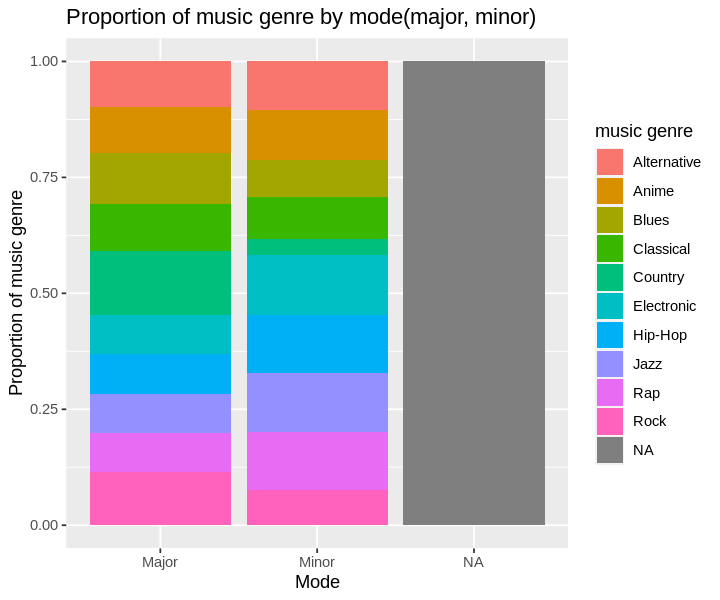

In [7]:
# proportion of music genre by mode(major, minor)
mode_proportion_plot <- data_train %>%
ggplot(aes(x = mode, fill = music_genre))+
geom_bar(position = "fill")+
labs(x = "Mode", y = "Proportion of music genre", fill = "music genre") +
ggtitle("Proportion of music genre by mode(major, minor)")
mode_proportion_plot

x Fold2: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...

x Fold3: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



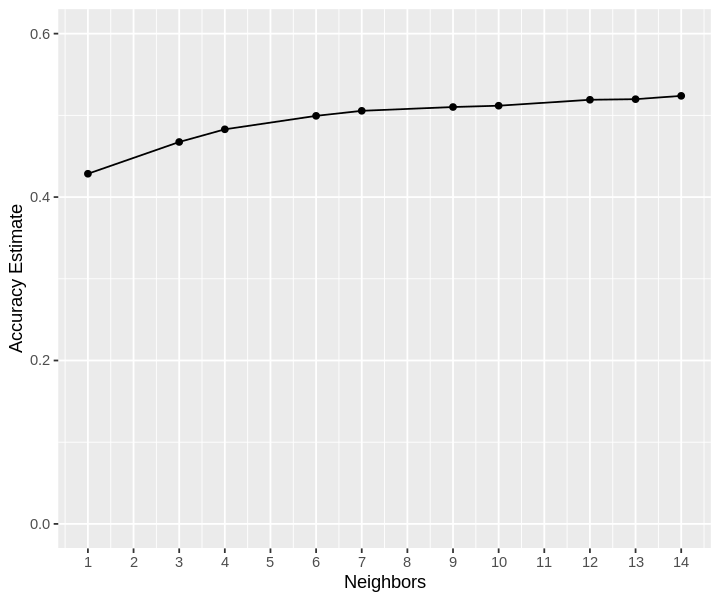

In [11]:
### Scale dataset
set.seed(1234) 

#find the best k

options(repr.plot.height = 5, repr.plot.width = 6)

data_recipe <- recipe(music_genre ~ popularity + acousticness + danceability + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + valence , data = data_train)


genre_vfold <- vfold_cv(data_train, v = 3, strata = music_genre)


data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")


data_results <- workflow() %>%
      add_recipe(data_recipe) %>%
      add_model(data_spec) %>%
      tune_grid(resamples = genre_vfold, grid = 10) %>%
      collect_metrics()

accuracies <- data_results %>%
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.0, 0.6)) # adjusting the y-axis
cross_val_plot



In [ ]:
# Set the seed. 
set.seed(9999) 
# build model
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
       set_engine("kknn") %>%
       set_mode("classification")
data_spec

data_fit <- workflow() %>%
       add_recipe(data_recipe) %>%
       add_model(data_spec) %>%
       fit(data = data_train)
data_fit

In [ ]:
#predictions
data_predictions <- predict(data_fit , data_test) %>%
      bind_cols(data_test)
data_predictions

data_metrics <- data_predictions %>%
       metrics(truth = music_genre, estimate = .pred_class)
data_metrics

data_conf_mat<- data_predictions %>%
       conf_mat(truth = music_genre, estimate = .pred_class) 
data_conf_mat

In [13]:
# test 1
knn_fit <- data_spec %>% fit(music_genre ~ popularity + acousticness + danceability + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + valence , data = data_train)
new_obs_1 <- tibble(popularity = 33, acousticness = 0.927, danceability = 0.351, duration_ms = 282067, energy = 0.0964, instrumentalness = 0.899, liveness = 0.509, loudness = -20.044, speechiness = 0.0436, valence = 0.246)
class_prediction_1 <-  predict(knn_fit, new_obs_1)



ERROR: Error in sort.int(x, na.last = na.last, decreasing = decreasing, ...): 'x' must be atomic


Timing stopped at: 0.006 0 0.006



In [14]:
# test 2
new_obs_2 <- tibble(popularity = 50, acousticness = 0.0145, danceability = 0.567, duration_ms = 268333, energy = 0.3, instrumentalness = 0, liveness = 0.0687, loudness = -8.421, speechiness = 0.0291, valence = 0.196)
class_prediction_2 <-  predict(knn_fit, new_obs_2)


ERROR: Error in predict(knn_fit, new_obs_2): object 'knn_fit' not found


In [15]:
# test 3
new_obs_2 <- tibble(popularity = 51, acousticness = 0.0341, danceability = 0.634, duration_ms = 248107, energy = 0.716, instrumentalness = 0, liveness = 0.0877, loudness = -6.502, speechiness = 0.128, valence = 0.619)
class_prediction_3 <-  predict(knn_fit, new_obs_3)


ERROR: Error in predict(knn_fit, new_obs_3): object 'knn_fit' not found
